In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt
# import fathon
# from fathon import fathonUtils as fu

# EDA

In [3]:
data = pd.read_excel('../data/ahr414_glucose_sample.xlsx', header=0)
data.head()

,PostDate,IngestionDate,PostId,PostTime,PatientId,Stream,SequenceNumber,TransmitterNumber,ReceiverNumber,RecordedSystemTime,...,GlucoseSystemTime,GlucoseDisplayTime,GlucoseDisplayTimeRaw,Value,Status,TrendArrow,TrendRate,IsBackFilled,InternalStatus,SessionStartTime
0,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:16:01.009,...,2022-09-13 23:15:45,2022-09-13 19:15:45,2022-09-13T19:15:45.000-04:00,111,NaN,Flat,0.2,False,6,5137335
1,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:20:57.025,...,2022-09-13 23:20:45,2022-09-13 19:20:45,2022-09-13T19:20:45.000-04:00,109,NaN,Flat,0.1,False,6,5137335
2,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:25:57.029,...,2022-09-13 23:25:45,2022-09-13 19:25:45,2022-09-13T19:25:45.000-04:00,111,NaN,Flat,0.1,False,6,5137335
3,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:30:57.030,...,2022-09-13 23:30:45,2022-09-13 19:30:45,2022-09-13T19:30:45.000-04:00,111,NaN,Flat,0.1,False,6,5137335
4,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:35:57.152,...,2022-09-13 23:35:45,2022-09-13 19:35:45,2022-09-13T19:35:45.000-04:00,110,NaN,Flat,0.0,False,6,5137335


In [4]:
data.dtypes

PostDate                  datetime64[ns]
IngestionDate             datetime64[ns]
PostId                            object
PostTime                  datetime64[ns]
PatientId                         object
Stream                            object
SequenceNumber                     int64
TransmitterNumber                 object
ReceiverNumber                   float64
RecordedSystemTime        datetime64[ns]
RecordedDisplayTime       datetime64[ns]
RecordedDisplayTimeRaw            object
TransmitterId                     object
TransmitterTime                    int64
GlucoseSystemTime         datetime64[ns]
GlucoseDisplayTime        datetime64[ns]
GlucoseDisplayTimeRaw             object
Value                              int64
Status                            object
TrendArrow                        object
TrendRate                        float64
IsBackFilled                        bool
InternalStatus                     int64
SessionStartTime                   int64
dtype: object

In [12]:
"""creating a column in the dataframe that's just the minute (since measures are every 5 minutes)"""
data['minute'] = ""
for time in range(len(data.GlucoseSystemTime)):
    data.at[time, 'minute'] = int(data.GlucoseSystemTime[time].minute)

In [14]:
"""check there's only the three patients"""
data.PatientId.unique()

array(['tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=',
       '9Fob2bu+MwNd3P522PazJ5pIV4l3jvx9Tf98DfxSdoU=',
       'iSFLmNjVJ3w4e4WcQtF3eMEKXOa4IKaeDjZ7Lra7l+Y='], dtype=object)

In [15]:
"""(better) check there's only the three patients"""
data.PatientId.value_counts()

tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=    580
iSFLmNjVJ3w4e4WcQtF3eMEKXOa4IKaeDjZ7Lra7l+Y=    575
9Fob2bu+MwNd3P522PazJ5pIV4l3jvx9Tf98DfxSdoU=    565
Name: PatientId, dtype: int64

In [16]:
"""check there's the same number of transmitters as patients"""
data.TransmitterId.unique()

array(['XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=',
       'PyW5hY6Hrg6Hdyjy59ZwN3vPapgM2Ym+6h45pblrcwQ=',
       'ooCpoqwYamjWbw9he1aD0nUS2ebxSd6xTiR+gnYgcIM='], dtype=object)

C:\Users\ljoe\AppData\Local\Temp\ipykernel_3140\2013474173.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,pat+1)


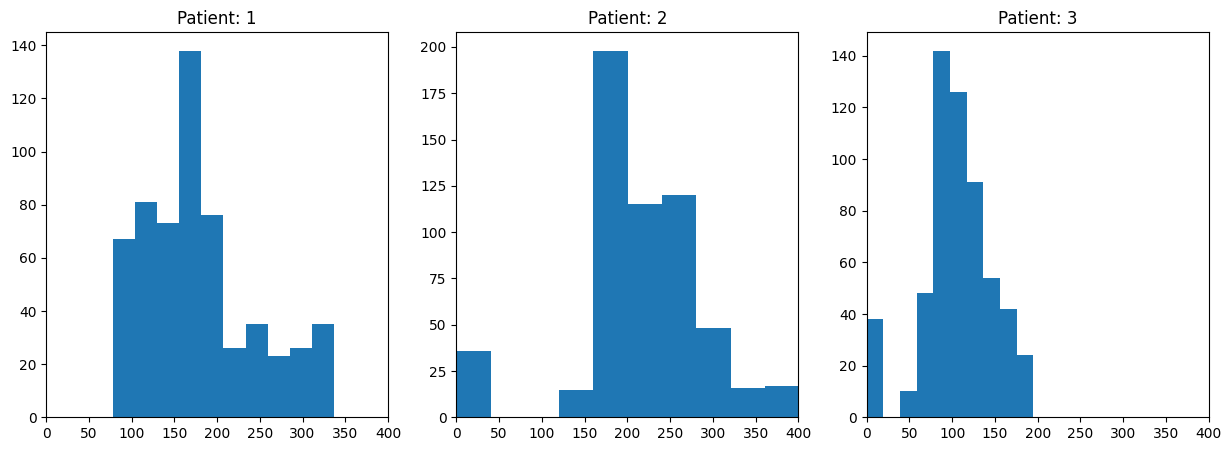

In [29]:
"""show histogram of glucose levels for each patient"""
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot()
patIDs = data.PatientId.unique()
for pat in range(len(patIDs)):
    plt.subplot(1,3,pat+1)
    subset = data.loc[data.PatientId == patIDs[pat]]
    plt.hist(subset.Value)
    plt.xlim([0, 400])
    plt.title("Patient: " + str(pat+1))
plt.show()

### Patient 1

Text(0.5, 1.0, "Patient 1's two-day Glucose Profile")

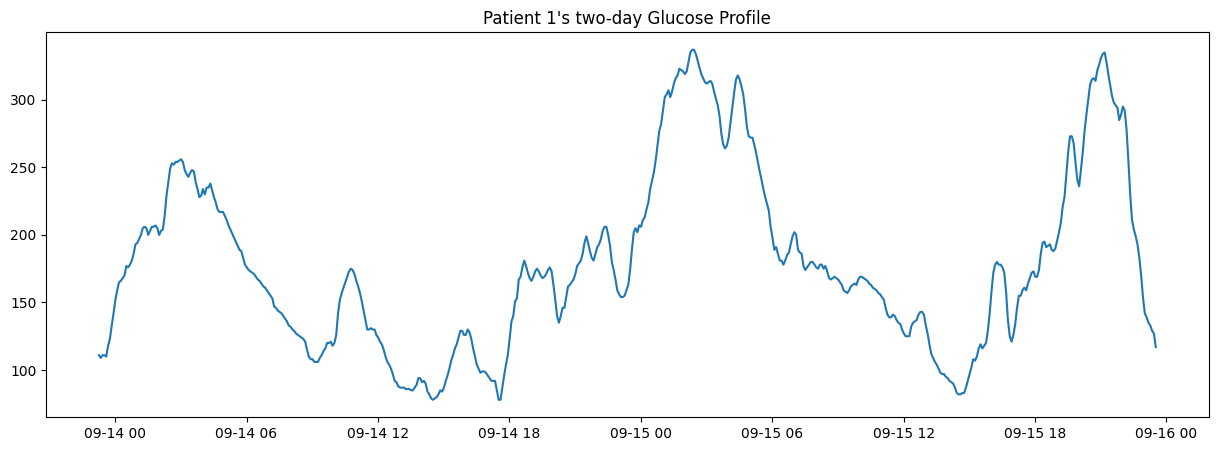

In [18]:
"""show glucose levels over two days, but just for Patient 1"""
pat1_df = data.loc[data.PatientId == patIDs[0]]
plt.plot(pat1_df.GlucoseSystemTime, pat1_df.Value)
# plt.plot(pat1_df.GlucoseSystemTime, le.transform(pat1_df.Status)*10)
plt.title("Patient 1's two-day Glucose Profile")

Text(0.5, 1.0, "Patient 1's two-day Glucodensity Plot")

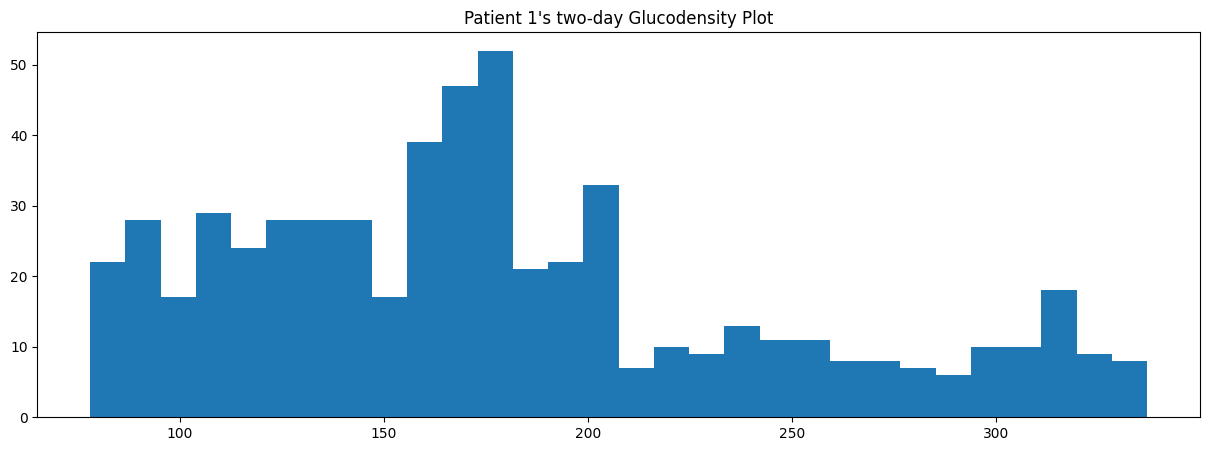

In [19]:
"""show histogram of glucose levels for just Patient 1"""
plt.hist(pat1_df.Value, 30)
plt.title("Patient 1's two-day Glucodensity Plot")

C:\Users\ljoe\AppData\Local\Temp\ipykernel_3140\3199366118.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,12,step+1)


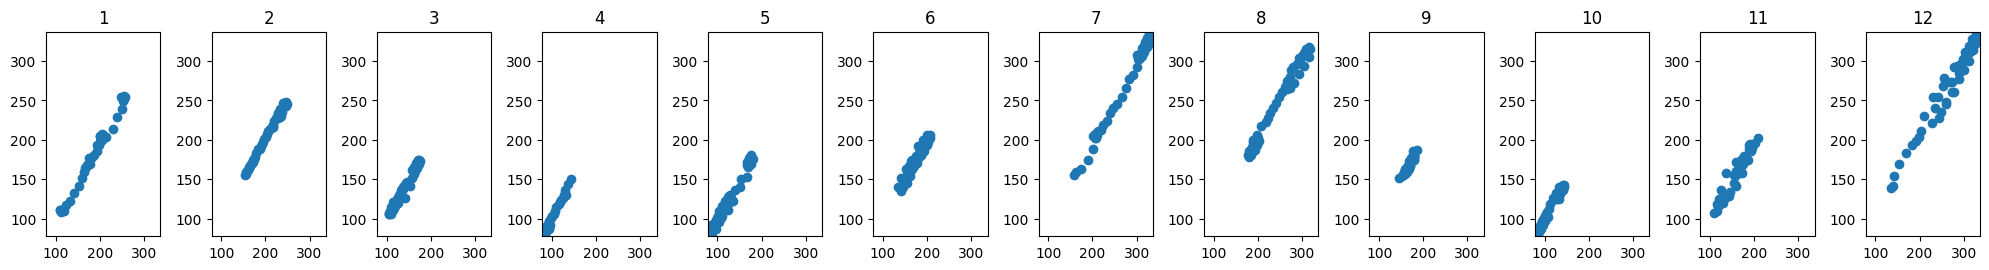

In [31]:
"""poincare plots of every 2 hours (glucose levels vs glucose levels but one step ahead)"""
plt.rcParams["figure.figsize"] = (20,5)
window = 24 # two hours
steps = len(pat1_df.Value)//window
plt.subplot()
for step in range(steps):
    plt.subplot(2,12,step+1)
    plt.scatter(pat1_df.Value[step*window+1 : (step+1)*window], pat1_df.Value[step*window : (step+1)*window-1])
    plt.xlim([pat1_df.Value.min(), pat1_df.Value.max()])
    plt.ylim([pat1_df.Value.min(), pat1_df.Value.max()])
    plt.title(str(step+1))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sample-Sample Dofferencing')

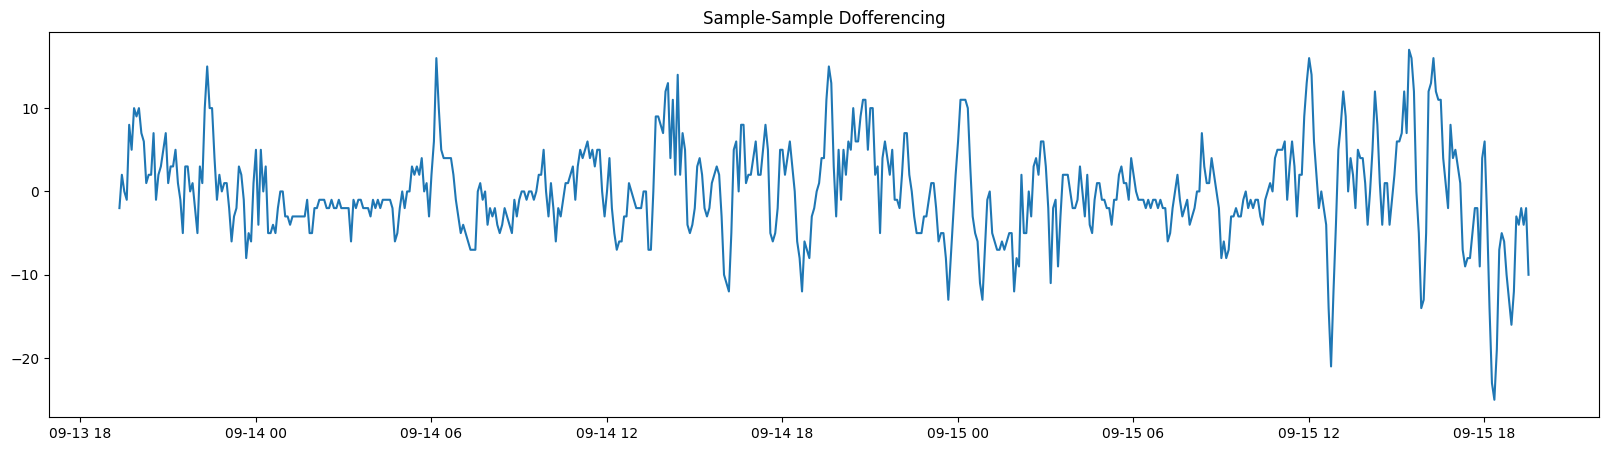

In [21]:
"""plot the DIFFERENCES in glucose levels over time (less variation than the glucose levels themselves)"""
pat1_df = data.loc[data.PatientId == patIDs[0]]
plt.plot(pat1_df.GlucoseDisplayTime[1:], np.diff(pat1_df.Value))
plt.title("Sample-Sample Differencing")

C:\Users\ljoe\AppData\Local\Temp\ipykernel_3140\2760537877.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,12,step+1)


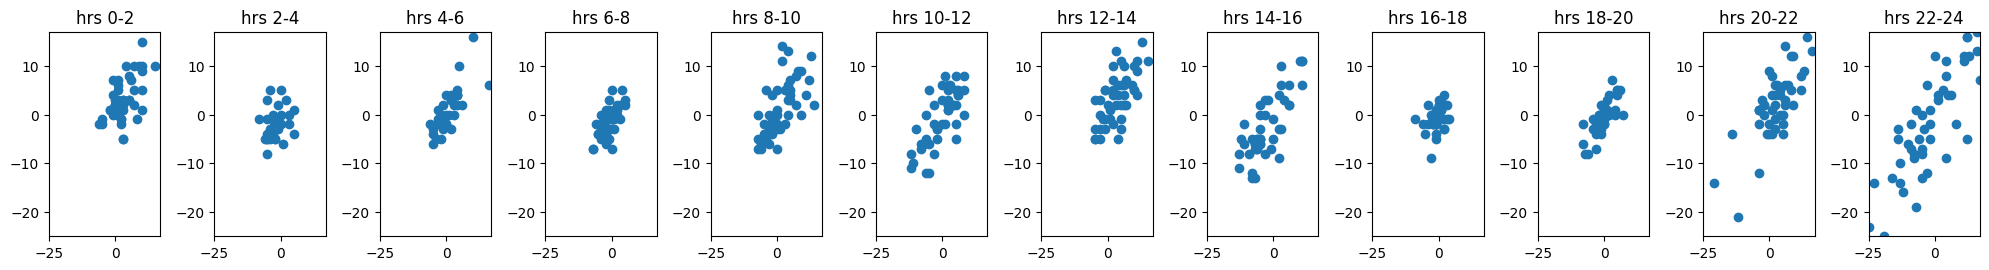

In [32]:
"""poincare plots of DIFFERENCES of every 2 hours (glucose level diffs vs glucose level diffs but one step ahead)"""
plt.rcParams["figure.figsize"] = (20,5)
window = 24 # 2 hours
steps = len(pat1_df.Value)//window
samp = np.diff(pat1_df.Value)
plt.subplot()
for step in range(steps):
    plt.subplot(2,12,step+1)
    plt.scatter(samp[step*window+1 : (step+1)*window-1], samp[step*window : (step+1)*window-2])
    plt.xlim([samp.min(), samp.max()])
    plt.ylim([samp.min(), samp.max()])
    plt.title("hr " + str(step*2) +"-"+ str((step+1)*2)) #assuming it's 2 hour windows
plt.tight_layout()

### Patient 2

Text(0.5, 1.0, "Patient 2's two-day Glucose Profile")

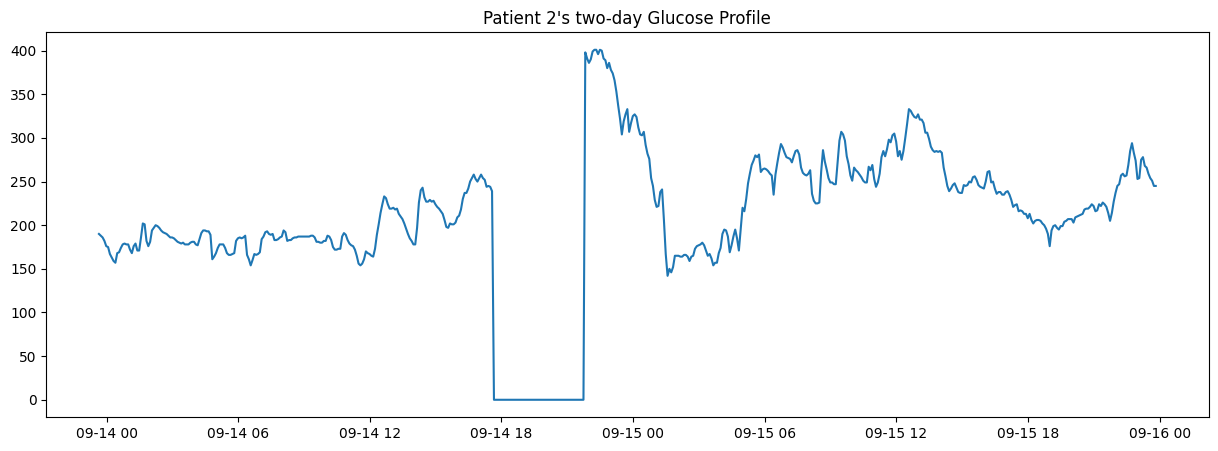

In [30]:
"""show glucose levels over two days, but just for Patient 2"""
pat2_df = data.loc[data.PatientId == patIDs[1]]
plt.plot(pat2_df.GlucoseSystemTime, pat2_df.Value)
# plt.plot(pat2_df.GlucoseSystemTime, le.transform(pat2_df.Status)*10)
plt.title("Patient 2's two-day Glucose Profile")

C:\Users\ljoe\AppData\Local\Temp\ipykernel_3140\1925308435.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,12,step+1)


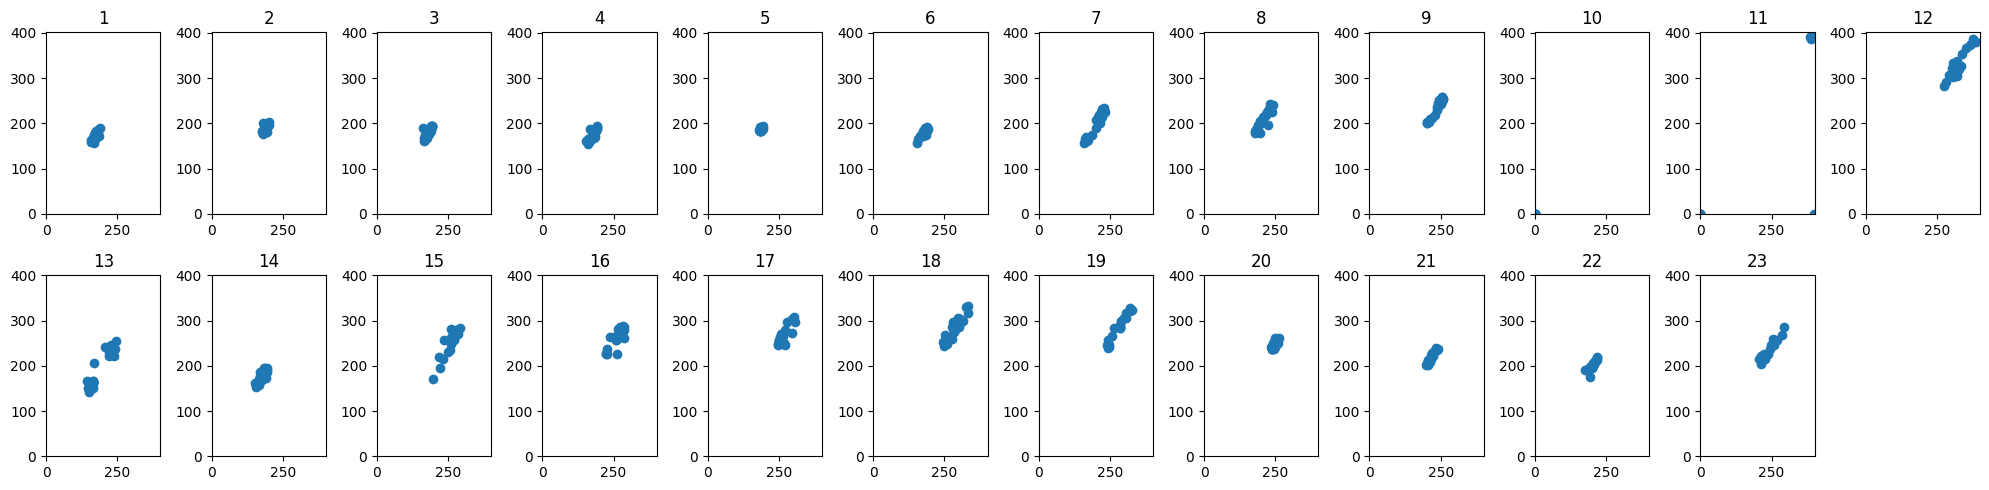

In [33]:
"""poincare plots of every 2 hours (glucose levels vs glucose levels but one step ahead)"""
plt.rcParams["figure.figsize"] = (20,5)
window = 24 # two hours
steps = len(pat2_df.Value)//window
plt.subplot()
for step in range(steps):
    plt.subplot(2,12,step+1)
    plt.scatter(pat2_df.Value[step*window+1 : (step+1)*window], pat2_df.Value[step*window : (step+1)*window-1])
    plt.xlim([pat2_df.Value.min(), pat2_df.Value.max()])
    plt.ylim([pat2_df.Value.min(), pat2_df.Value.max()])
    plt.title(str(step+1))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sample-Sample Dofferencing')

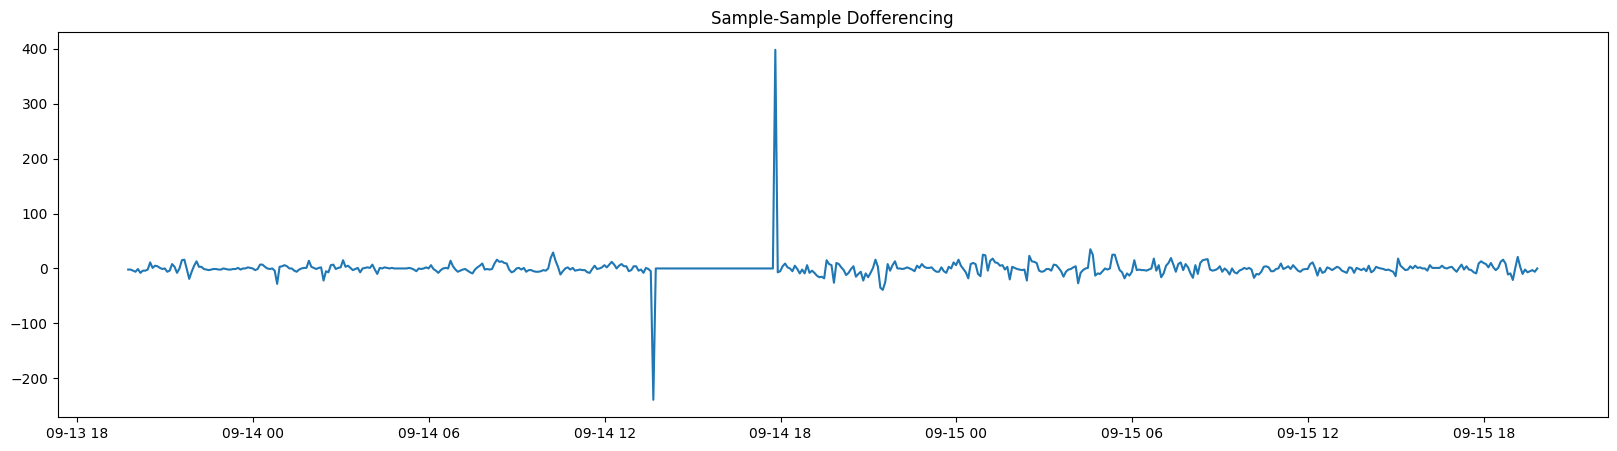

In [37]:
"""plot the DIFFERENCES in glucose levels over time (less variation than the glucose levels themselves)"""
# pat2_df = data.loc[data.PatientId == patIDs[1]]
plt.plot(pat2_df.GlucoseDisplayTime[1:], np.diff(pat2_df.Value))
plt.title("Sample-Sample Differencing")

564
562


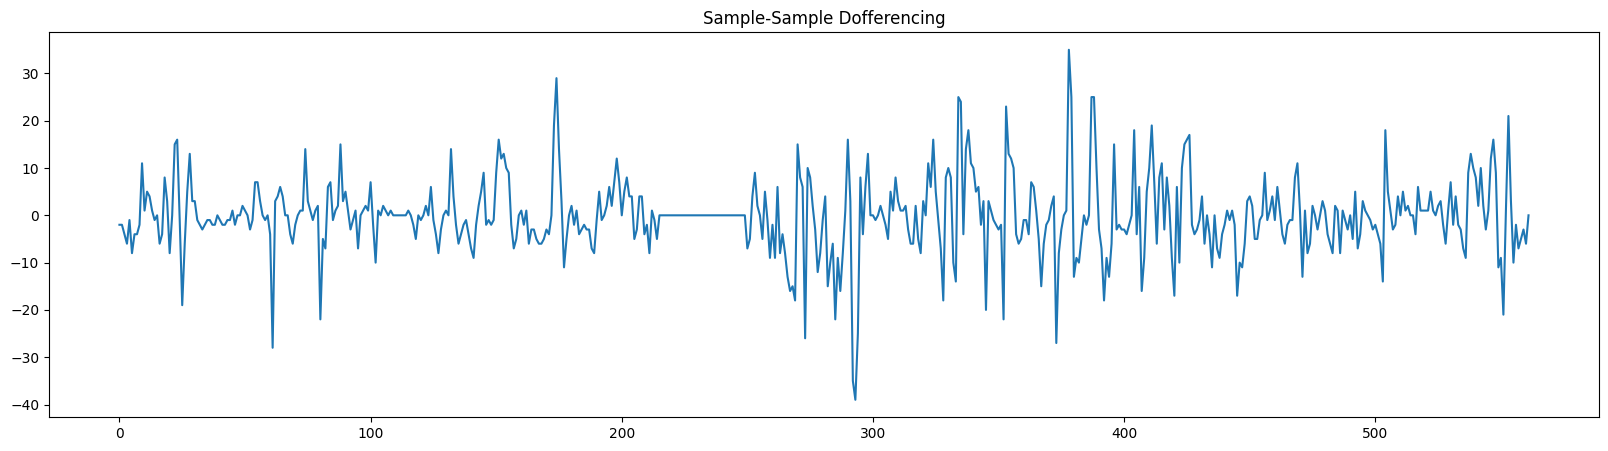

In [45]:
samp = np.diff(pat2_df.Value)
print(len(samp))
# np.std(samp)
samp = samp[(samp<=3*np.std(samp)) & (samp>=-3*np.std(samp))]

'''show what the data looks like now'''
_ = np.linspace(0, len(samp)-1, len(samp))
plt.plot(_, samp)
plt.title("Sample-Sample Differencing")
print(len(samp))

C:\Users\ljoe\AppData\Local\Temp\ipykernel_3140\3129955717.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,12,step+1)


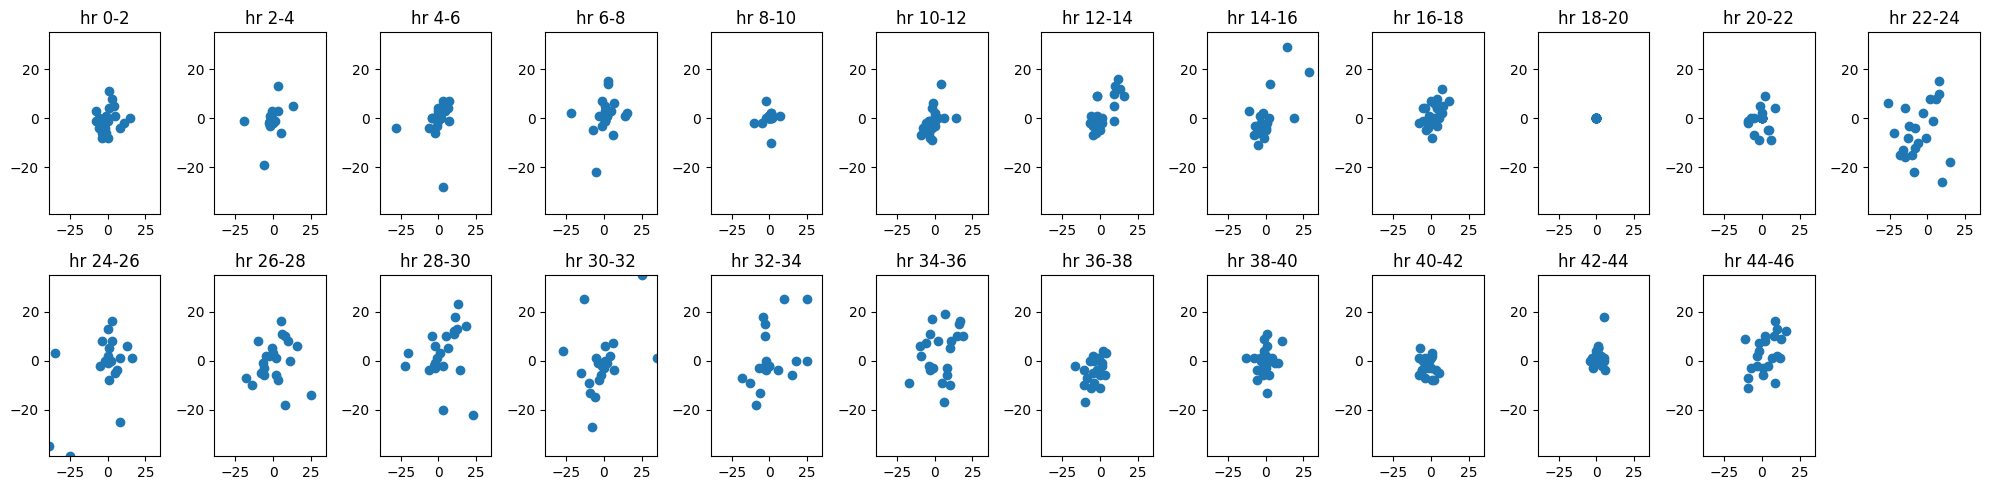

In [46]:
"""poincare plots of DIFFERENCES of every 2 hours (glucose level diffs vs glucose level diffs but one step ahead)"""
plt.rcParams["figure.figsize"] = (20,5)
window = 24 # 2 hours
steps = len(pat2_df.Value)//window
samp = np.diff(pat2_df.Value)
samp = samp[(samp<=3*np.std(samp)) & (samp>=-3*np.std(samp))] #get rid of the drop-offs
plt.subplot()
for step in range(steps):
    plt.subplot(2,12,step+1)
    plt.scatter(samp[step*window+1 : (step+1)*window-1], samp[step*window : (step+1)*window-2])
    plt.xlim([samp.min(), samp.max()])
    plt.ylim([samp.min(), samp.max()])
    plt.title("hr " + str(step*2) +"-"+ str((step+1)*2)) #assuming it's 2 hour windows
plt.tight_layout()

### Patient 3

Text(0.5, 1.0, "Patient 3's two-day Glucose Profile")

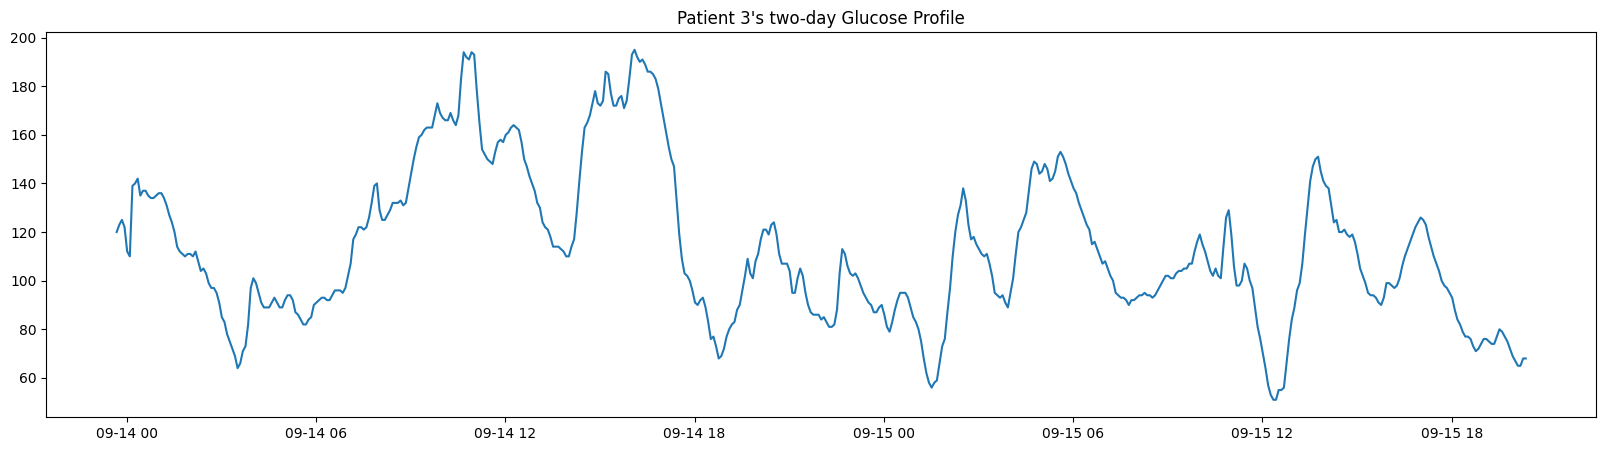

In [48]:
"""show glucose levels over two days, but just for Patient 3"""
pat3_df = data.loc[data.PatientId == patIDs[2]]
pat3_df = pat3_df[pat3_df["Value"]>0] #got rid of 0s because they're at the end and don't get in the way of timestamps in the same way patient2's did
plt.plot(pat3_df.GlucoseSystemTime, pat3_df.Value)
plt.title("Patient 3's two-day Glucose Profile")

C:\Users\ljoe\AppData\Local\Temp\ipykernel_3140\1570178267.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,12,step+1)


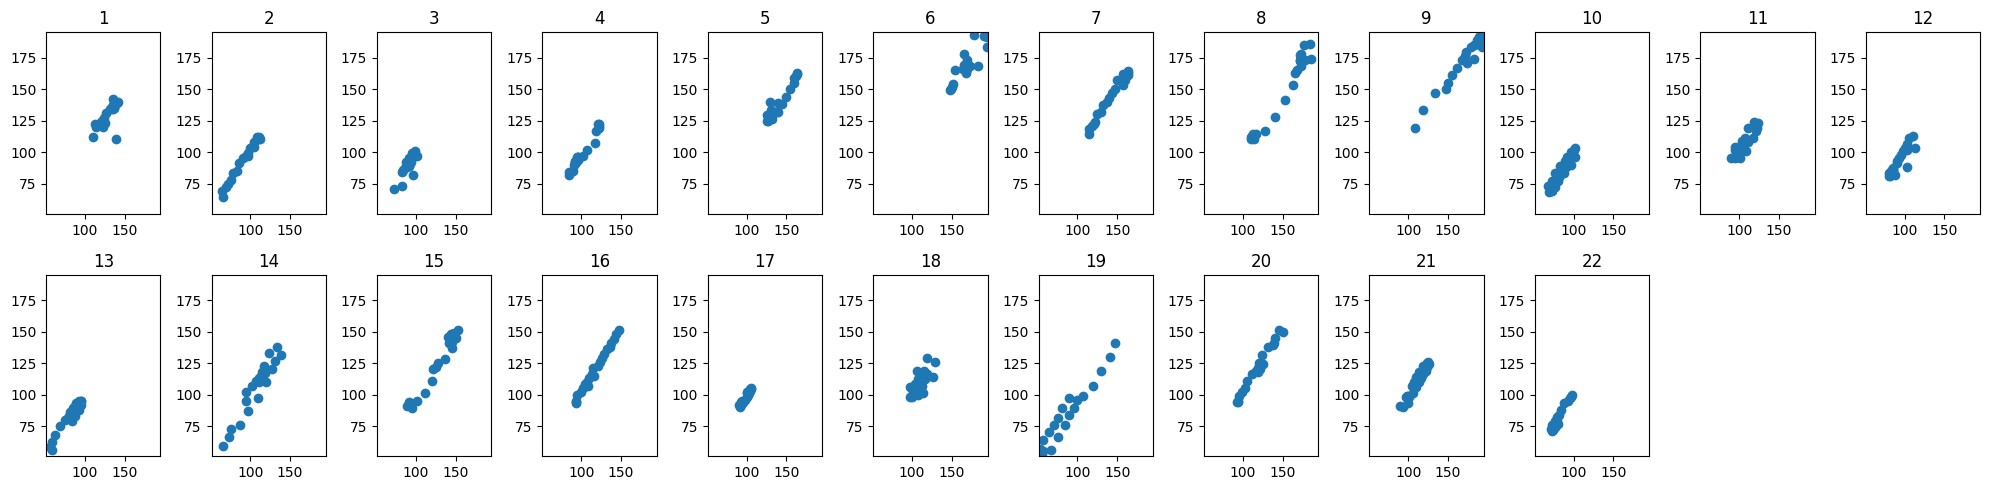

In [49]:
"""poincare plots of every 2 hours (glucose levels vs glucose levels but one step ahead)"""
plt.rcParams["figure.figsize"] = (20,5)
window = 24 # two hours
steps = len(pat3_df.Value)//window
plt.subplot()
for step in range(steps):
    plt.subplot(2,12,step+1)
    plt.scatter(pat3_df.Value[step*window+1 : (step+1)*window], pat3_df.Value[step*window : (step+1)*window-1])
    plt.xlim([pat3_df.Value.min(), pat3_df.Value.max()])
    plt.ylim([pat3_df.Value.min(), pat3_df.Value.max()])
    plt.title(str(step+1))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sample-Sample Differencing')

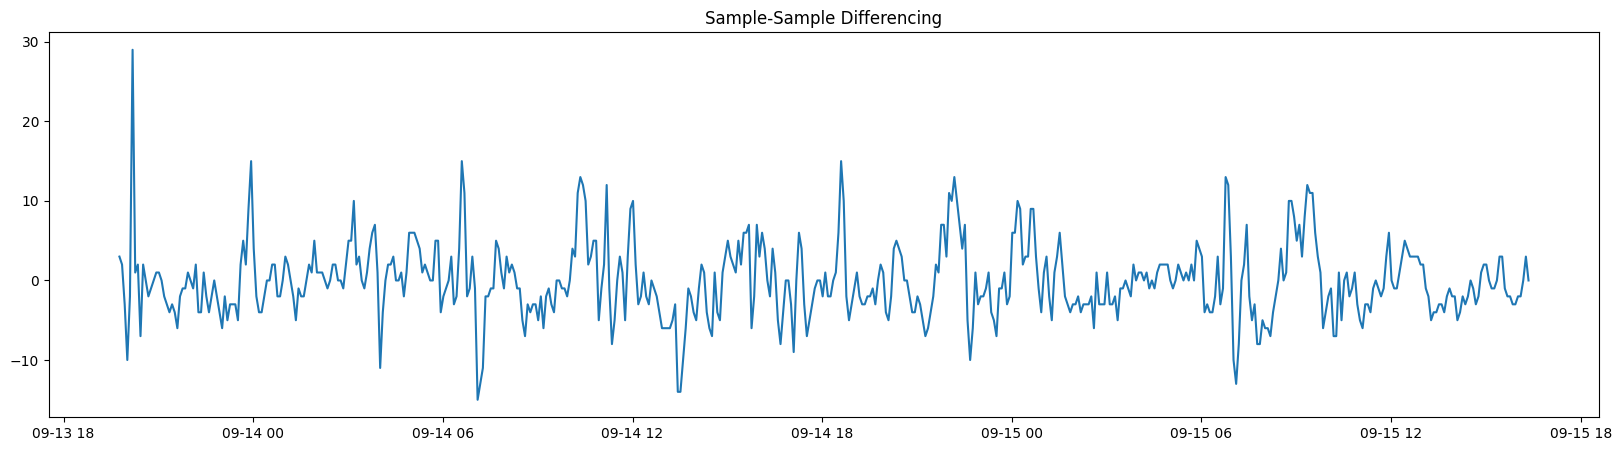

In [51]:
"""plot the DIFFERENCES in glucose levels over time (less variation than the glucose levels themselves)"""
plt.plot(pat3_df.GlucoseDisplayTime[1:], np.diff(pat3_df.Value))
plt.title("Sample-Sample Differencing")

C:\Users\ljoe\AppData\Local\Temp\ipykernel_3140\1734650736.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,12,step+1)


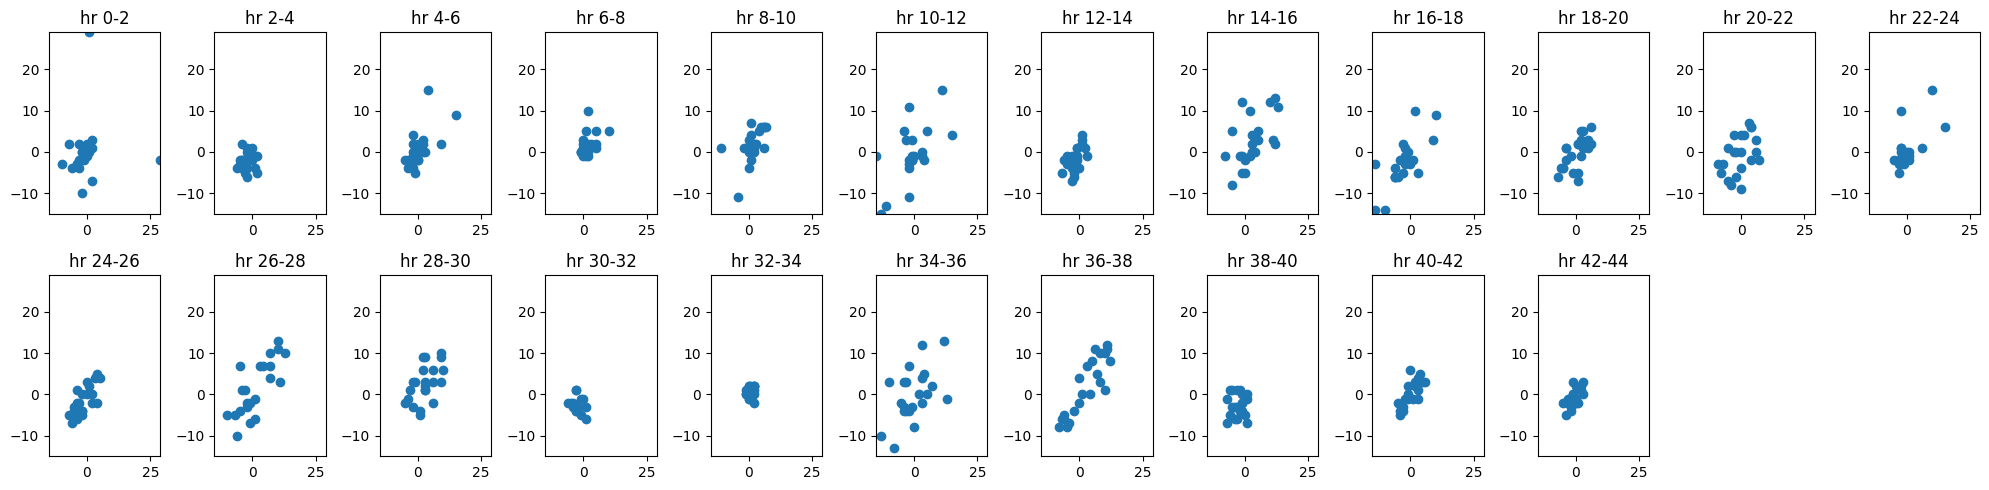

In [52]:
"""poincare plots of DIFFERENCES of every 2 hours (glucose level diffs vs glucose level diffs but one step ahead)"""
plt.rcParams["figure.figsize"] = (20,5)
window = 24 # 2 hours
steps = len(pat3_df.Value)//window
samp = np.diff(pat3_df.Value)
plt.subplot()
for step in range(steps):
    plt.subplot(2,12,step+1)
    plt.scatter(samp[step*window+1 : (step+1)*window-1], samp[step*window : (step+1)*window-2])
    plt.xlim([samp.min(), samp.max()])
    plt.ylim([samp.min(), samp.max()])
    plt.title("hr " + str(step*2) +"-"+ str((step+1)*2)) #assuming it's 2 hour windows
plt.tight_layout()

# not poincare EDA

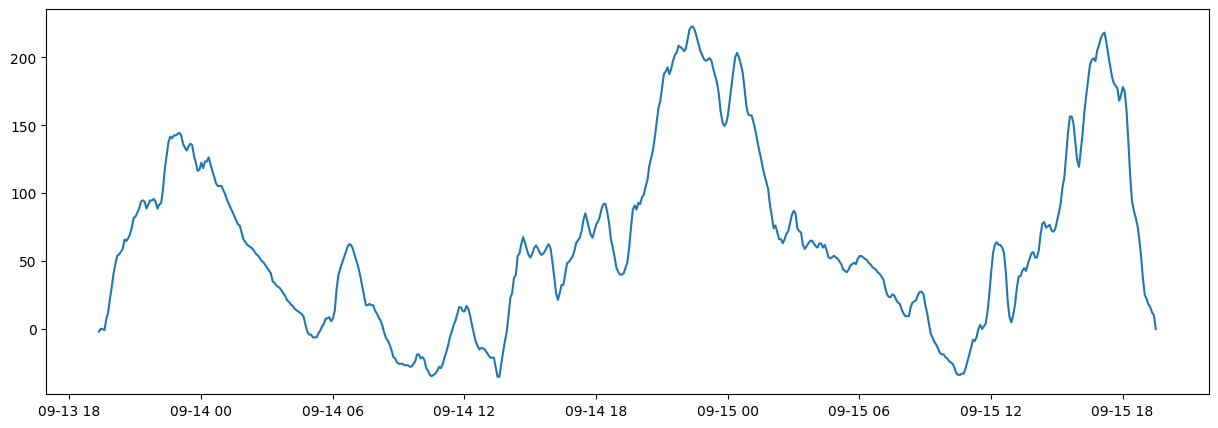

In [20]:
plt.rcParams["figure.figsize"] = (15,5)
diff_pat1 = np.diff(pat1_df.Value)
diff_pat1 = diff_pat1 - diff_pat1.mean()

a = fu.toAggregated(diff_pat1)
plt.plot(pat1_df.GlucoseDisplayTime[1:], a)

In [23]:
# initialize mfdfa object
pymfdfa = fathon.MFDFA(a)
# compute fluctuation function and generalized Hurst exponents
wins = fu.linRangeByStep(10, 100)
n, F = pymfdfa.computeFlucVec(wins, np.arange(-3, 4, 0.1), revSeg=True, polOrd=1)
list_H, list_H_intercept = pymfdfa.fitFlucVec()

# compute mass exponents
tau = pymfdfa.computeMassExponents()

# compute multifractal spectrum
alpha, mfSpect = pymfdfa.computeMultifractalSpectrum()

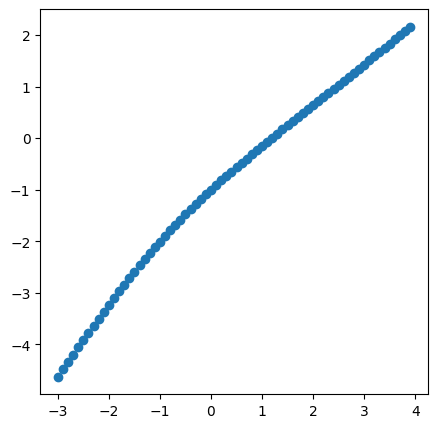

In [24]:
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(np.arange(-3,4,0.1), tau)

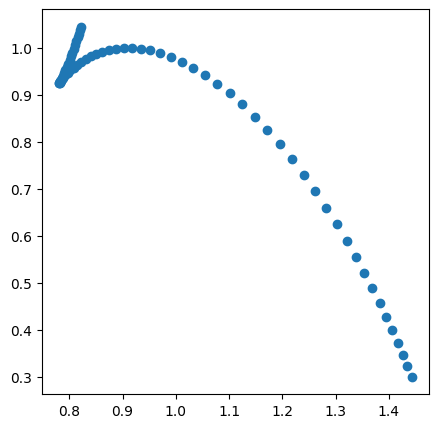

In [25]:
plt.scatter(alpha, mfSpect)

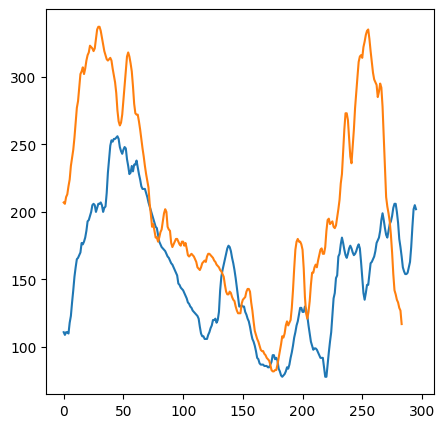

In [26]:
for date in data.PostDate.unique():
    sep_day = pat1_df.loc[data.PostDate == date]
    sep_day.reset_index(inplace=True)
    plt.plot(sep_day.Value)

NameError: name 'le' is not defined

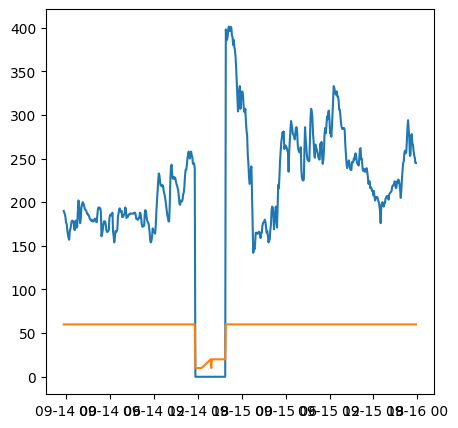

In [27]:
pat2_df = data.loc[data.PatientId == patIDs[1]]
plt.plot(pat2_df.GlucoseSystemTime, pat2_df.Value)
plt.plot(pat2_df.GlucoseSystemTime, pat2_df.InternalStatus*10)
plt.plot(pat2_df.GlucoseSystemTime, le.transform(pat2_df.Status)*10)

# pointcare tests

### straight from the documentation

https://pyhrv.readthedocs.io/en/latest/_pages/api/nonlinear.html#poincare-poincare

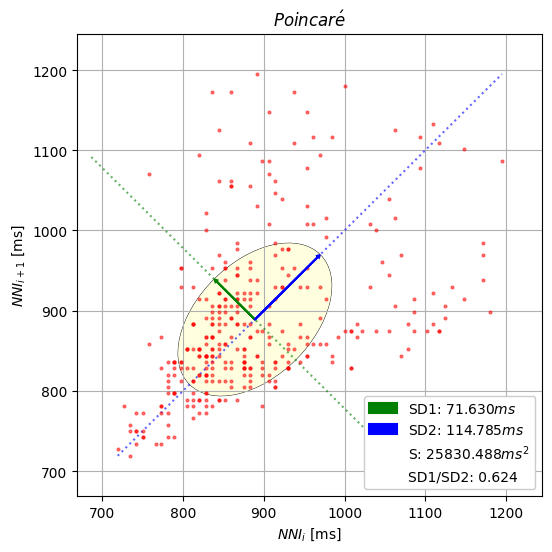

71.63036373757002


In [28]:
# Import packages
import pyhrv
import pyhrv.nonlinear as nl

# Load sample data
nni = pyhrv.utils.load_sample_nni()

# Compute Poincaré using NNI series
results = nl.poincare(nni)

# Print SD1
print(results['sd1'])

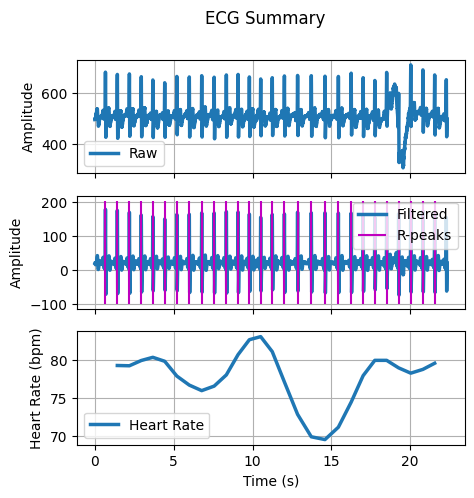

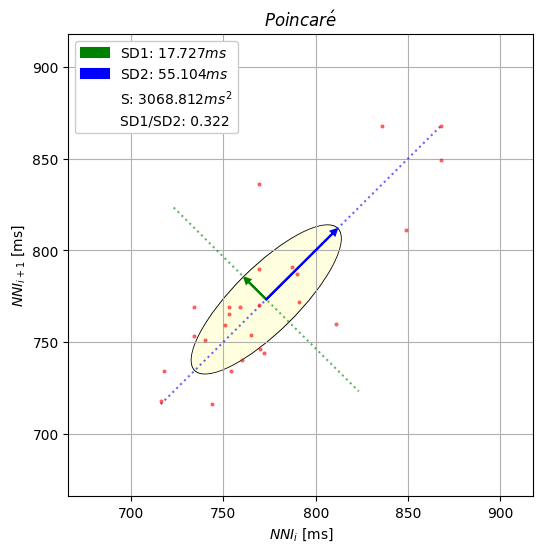

In [32]:
# Import packages
import biosppy
import pyhrv.nonlinear as nl

# Load sample ECG signal
signal = np.loadtxt('../data/SampleECG.txt')[:, -1] #local file

# Get R-peaks series using biosppy
t, _, rpeaks = biosppy.signals.ecg.ecg(signal)[:3]

# Compute Poincaré using R-peak series
results = pyhrv.nonlinear.poincare(rpeaks=t[rpeaks])

In [45]:
len(signal)

22350

### my attempts

In [5]:
'''jamie's code'''

def eclipseFittingMethod(IDI):
	"""
	Input		:
	- IDI	     : [list] of inter-data intervals (diff(time_series))
	Output	:
	- SD1, SD2 : {dict} with keys 'SD1' (numpy.float64), representing short-term
			 variation, and 'SD2' (numpy.float64), representing long-term
			 variation
	"""
	SDSD = np.std(np.diff(IDI))
	SDRR = np.std(IDI)
	SD1 = (1 / np.sqrt(2)) * SDSD #measures the width of poincare cloud
	SD2 = np.sqrt((2 * SDRR ** 2) - (0.5 * SDSD ** 2)) #measures the length of the poincare cloud
	
	return {'SD1': round(SD1,3), 'SD2': round(SD2,3), 'SD_ratio': round(SD1/SD2,3)}

In [46]:
pat1_glucose_list = pat1_df.Value.to_list()
pat1_glucose_poincare = eclipseFittingMethod(np.diff(pat1_glucose_list))
pat1_glucose_poincare

{'SD1': 4.036, 'SD2': 92.747, 'SD_ratio': 0.044}

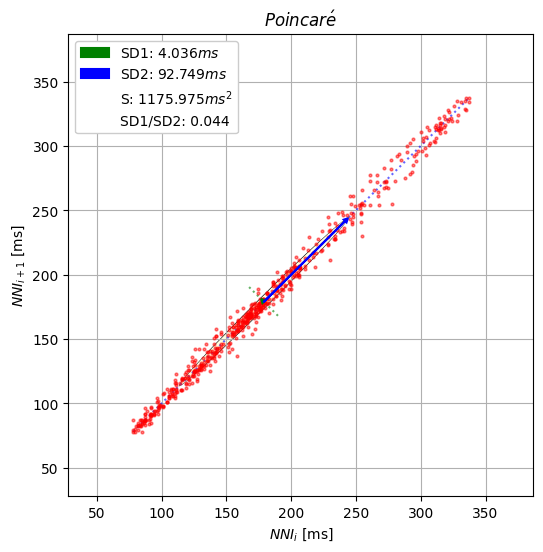

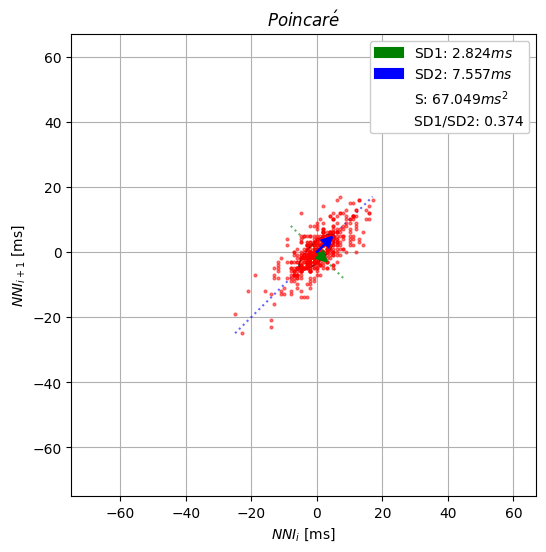

In [50]:
results = nl.poincare(pat1_glucose_list)
results = nl.poincare(np.diff(pat1_glucose_list))

In [51]:
t, _, rpeaks = biosppy.signals.ecg.ecg(np.diff(pat1_glucose_list))[:3]

results = pyhrv.nonlinear.poincare(rpeaks=t[rpeaks])

ValueError: The length of the input vector x must be greater than padlen, which is 903.

# wrapper function

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_excel('../data/ahr414_glucose_sample.xlsx', header=0)
data.PatientId.unique()

array(['tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=',
       '9Fob2bu+MwNd3P522PazJ5pIV4l3jvx9Tf98DfxSdoU=',
       'iSFLmNjVJ3w4e4WcQtF3eMEKXOa4IKaeDjZ7Lra7l+Y='], dtype=object)

In [2]:
data.PatientId.value_counts()

tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=    580
iSFLmNjVJ3w4e4WcQtF3eMEKXOa4IKaeDjZ7Lra7l+Y=    575
9Fob2bu+MwNd3P522PazJ5pIV4l3jvx9Tf98DfxSdoU=    565
Name: PatientId, dtype: int64

In [3]:
data.TransmitterId.unique()

array(['XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=',
       'PyW5hY6Hrg6Hdyjy59ZwN3vPapgM2Ym+6h45pblrcwQ=',
       'ooCpoqwYamjWbw9he1aD0nUS2ebxSd6xTiR+gnYgcIM='], dtype=object)

In [4]:
def poincare_wrapper(data: pd.DataFrame):
	"""
	INPUT			:
	- data		  : cleaned DataFrame with verified unique patient-per-transmitter
	OUTPUT			:
	- poincare_df : DataFrame of 3xn where n is the number of patients, and the 3
					columns are 'SD1', 'SD2', 'SD_ratio' (as definied by the func-
					tion eclipseFittingMethod())
	"""

	'''jamie's code'''
	def eclipseFittingMethod(IDI):
		"""
		Input		:
		- IDI	   : [list] of inter-data intervals (diff(time_series))
		Output		:
		- SD1, SD2 : {dict} with keys 'SD1' (numpy.float64), representing short-term
					 variation, and 'SD2' (numpy.float64), representing long-term
					 variation
		"""
		SDSD = np.std(np.diff(IDI))
		SDRR = np.std(IDI)
		SD1 = (1 / np.sqrt(2)) * SDSD #measures the width of poincare cloud
		SD2 = np.sqrt((2 * SDRR ** 2) - (0.5 * SDSD ** 2)) #measures the length of the poincare cloud
		
		return {'SD1': round(SD1,3), 'SD2': round(SD2,3), 'SD_ratio': round(SD1/SD2,3)}
	

	poincare_df = pd.DataFrame(columns=['SD1', 'SD2', 'SD_ratio'])

	patIDs = data.PatientId.unique()
	for i in range(len(patIDs)):
		single_pat = data.loc[data.PatientId == patIDs[i]]

		glucose_diff = np.diff(single_pat.Value)
		poincare_df.loc[len(poincare_df)+1] = eclipseFittingMethod(glucose_diff)
	
	return poincare_df

poincare_wrapper(data)

,SD1,SD2,SD_ratio
1,2.824,7.562,0.373
2,20.642,21.579,0.957
3,4.022,6.387,0.630
